In [ ]:
import numpy as np
import pandas as pd
from typing import Optional
from dataclasses import dataclass
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [ ]:
# https://finance.naver.com/sise/sise_group_detail.naver?type=upjong&no=301 - 은행
# https://finance.naver.com/sise/sise_group_detail.naver?type=upjong&no=282 - 전기전자
# https://finance.naver.com/sise/sise_group_detail.naver?type=upjong&no=268 - 식품

item_codes__301 = [
    "A006220", "A038540", "A055550", "A316140", "A139130", "A024110", "A105560",
    "A175330", "A086790", "A323410", "A138930",
]
item_codes__282 = [
    "A053450", "A131400", "A082210", "A015260", "A078600", "A336370", "A347890",
    "A060230", "A017900", "A017250", "A35320K", "A33637K", "A251630", "A032820",
    "A072990", "A089980", "A225190", "A353200", "A090460", "A115530", "A331380",
    "A121890", "A099520", "A058530", "A050320", "A091340", "A098460", "A222800",
    "A263810", "A007660", "A347000", "A096040", "A33637L", "A084850", "A020150",
    "A140860", "A066900", "A069510", "A204270", "A236200", "A00781K", "A203450",
    "A187220", "A007815", "A080420", "A248070", "A361670", "A051370", "A143160",
    "A007810", "A054090", "A009155", "A036710", "A068240", "A052020", "A320000",
    "A009150", "A008110", "A072950", "A161580", "A031330", "A318020", "A300120",
    "A033240", "A317770", "A348350", "A092300", "A094840", "A106520", "A033320",
    "A004270", "A125210", "A093520", "A068940", "A264850", "A032960", "A038460",
    "A016920", "A057540", "A085670", "A262260", "A046310", "A333620", "A083640",
    "A299030", "A011070", "A340930", "A011230", "A033200", "A004770",
]
item_codes__268 = [
    "A005745", "A103840", "A003960", "A003230", "A004415", "A004370", "A084695", 
    "A097950", "A072710", "A001795", "A004970", "A195500", "A900340", "A010600",
    "A007310", "A006090", "A260970", "A097955", "A001680", "A005180", "A001685", 
    "A290720", "A011155", "A003380", "A017810", "A088910", "A001800", "A066360", 
    "A267980", "A005860", "A003925", "A049770", "A002600", "A339770", "A001130", 
    "A005610", "A006040", "A003680", "A26490K", "A00499K", "A026960", "A005990", 
    "A248170", "A003920", "A009780", "A004990", "A008040", "A271560", "A280360", 
    "A073560", "A002680", "A035810", "A014710", "A145995", "A002140", "A136480", 
    "A007540", "A003310", "A218150", "A002270", "A000075", "A030720", "A027710",
    "A353810", "A004410", "A084690", "A007160", "A036580", "A357230", "A011150",
    "A140410", "A000070", "A002760", "A136490", "A222980", "A016790", "A027740",
    "A003580", "A005670", "A145990", "A006980", "A005740", "A025880", "A101530",
    "A264900", "A001790", "A277410", "A208140", "A025870",
]

In [ ]:
data = pd.read_csv('ouprocess_test.csv', index_col=0)

In [ ]:
data

In [ ]:
# brownian motion
# is continuous process such that its increments (small change in value) for any time scale are drawn from a normal distribution
# A.K.A for all n (n<t), if every W(t-n) - w(t-n-1) (= increments) are independent and normally distributed (markove property)
# If the increments are defined on a unit of time, then the distribution is the standard normal, zero mean, unit variance.

def get_dW(
    T : int,
    # Optional is used to show the parameter type which is allowed to use None
    random_state : Optional[int] = None
) -> np.ndarray:
    
    """
    Tp simulate dW(discrete increments of Sample T times from a normal distribution) of a Brownian Motion.
    Random state is optional to reproduce results.
    """
    np.random.seed(random_state)
    return np.random.normal(0.0, 1.0, T)


def get_W(
    T : int,
    random_state : Optional[int] = None
) -> np.ndarray:
    
    """
    To simulate a brownian motion 
    """
    
    dW = get_dW(T, random_state)
    # to cumulate sum and then make the fist index 0 and delete last element.
    dW_cs = dW.cumsum()
    dW_cs = np.insert(dW_cs, 0, 0)[:-1]
    return dW_cs

In [ ]:
dW = get_dW(T=1_000)
W = get_W(T=1_000)

#----------------------------------------------------------------
# plot

import matplotlib.pyplot as plt 
import seaborn as sns

fig = plt.figure(figsize=(15, 5))

title = "Brownian motion increments"
plt.subplot(1, 2, 1)
plt.plot(dW)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Brownian motion path"
plt.subplot(1, 2, 2)
plt.plot(W, 'r-')
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
# brownian motion can be correlated to another brownian motion.
# Let W_1 is brownian motion and correlated with W_3 which correlation is rho and W_2 is another independent brownian motion
# Then, dW_3t = rho * dW_1t + sqrt(1 - rho^2) * dW_2t

def _get_correlated_dW(
    dW : np.ndarray,
    rho : float,
    random_state : Optional[int] = None,
) -> np.ndarray:
    """
    Sample new brownian increments which is correlated with given increments dW and rho
    """
    
    # generate brownian increments
    dW2 = get_dW(len(dW),random_state)
    
    if np.array_equal(dW2, dW):
        # dW cannot be equal to dW2
        raise ValueError(
            "Brownian Increment error, try choosing different random state."
        )
        
    dW3 = rho * dW + np.sqrt(1 - rho ** 2) * dW2
    return dW3
    
    
# To generate many correlated brownian motion (=N-dimentional Wiener process) which corr is rho

def get_corr_dW_matrix(
    T : int, # the number of samples of each process
    n_process : int, # the numper of process 
    rho : Optional[float] = None,
    random_state : Optional[int] = None,
) -> np.ndarray : 
    """
    The correlation constant rho is used to generate a new process,
    which has rho correlation to a random process already generated,
    hence rho is only an approximation to the pairwise correlation.
    
    The resulting shape of the array is (T, n_procs).
    """
    # generate random value
    rng = np.random.default_rng(random_state)
    dWs : list[np.ndarray] = []
        
    for i in range(n_process):
        # to produce diffirent brownian motion
        random_state_i = _get_random_state_i(random_state, i)
        if i == 0 or rho is None:
            dW_i = get_dW(T,random_state=random_state_i)
        else:
            # get andom process in dWs
            dW_corr_ref = _get_corr_ref_dW(dWs, i, rng)
            dW_i = _get_correlated_dW(dW_corr_ref, rho, random_state_i)
        dWs.append(dW_i)
    return np.asarray(dWs).T

    
def _get_random_state_i(
    random_state : Optional[int],
    i : int
) -> Optional[int]:
    """Add i to random_state is is int, else return None."""
    return random_state if random_state is None else random_state + i


def _get_corr_ref_dW(
    # dWs : list[np.ndarray], 
    dWs : list,
    i : int, 
    rng : np.random.Generator
) -> np.ndarray:
    """
    Choose randomly a process (dW) from the
    already generated processes (dWs).
    """
    random_proc_idx = rng.choice(i)
    return dWs[random_proc_idx]

In [ ]:
T = 1_000
n_procs = 53
rho = 0.9

corr_dWs = get_corr_dW_matrix(T, n_procs, rho)

#----------------------------------------------------------------
# plot

import matplotlib.pyplot as plt 
import seaborn as sns

fig = plt.figure(figsize=(15, 5))

# paths
title = "Correlated Brownian motion paths"
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(corr_dWs, axis=0))
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# correlation
title = "Correlation matrix heatmap"
plt.subplot(1, 2, 2)
sns.heatmap(np.corrcoef(corr_dWs, rowvar=False), cmap="viridis")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
import brownian_motion

In [55]:
# Ornstein-Uhlenbeck process is not just stationary but also normally distributed
# ou parameter : dXt = mu(theta - Xt)dt + sigma * dBt
#      - Bt : Brownian Motion
#      - mu : deterministic part & the drift of the process 
#      - sigma : control the random process 
#      - If sigma is large enough, then mu become unsignificant for the process

@dataclass
class OUParams:
    mu: float  # mean reversion parameter
    theta: float  # asymptotic mean
    sigma: float  # Brownian motion scale (standard deviation)
        

def get_OU_process(
    T : int,
    OU_params : OUParams,
    # X_0 is initial value for the process.
    X_0 : Optional[float] = None,
    random_state : Optional[int] = None
) -> np.ndarray : 
    """Solution of the SDE
    X_t = X_0 * e^(-mu * t) 
          + theta(1-e^(-mu * t)) 
          + sigma * e^(-mu * t) * integral 0 ~ t e^(-mu * t)*dWs
    """
    t = np.arange(T,dtype='float64') # float to avoid np.exp overflow
    # part of the SDE
    exp_mu_t = np.exp(-OU_params.mu * t)
    dB = brownian_motion.get_dW(T, random_state)
    integral_B = _get_integral_B(t, dB, OU_params)
    _X_0 = _select_X_0(X_0, OU_params)
    
    return (
        _X_0 * exp_mu_t 
        + OU_params.theta * (1-exp_mu_t)
        + OU_params.sigma * exp_mu_t * integral_B
    )
    
    
def _select_X_0(
    X_0_in : Optional[float],
    OU_params : OUParams
) -> float:
    """
    X_0 is initial value for the process.
    if None, the X_0 is taken to be theta (asymptotic mean)
    """
    if X_0_in is not None:
        return X_0_in
    return OU_params.theta
    
    
def _get_integral_B(
    t : np.ndarray,
    dW : np.ndarray,
    OU_params : OUParams,
) -> np.ndarray :
    """Integral with respect to Brownian Motion (W), ∫...dW."""
    exp_mu_s = np.exp(OU_params.mu * t)
    integral_B = np.cumsum(exp_mu_s * dW)
    return np.insert(integral_B, 0, 0)[:-1]

In [ ]:
OU_params = OUParams(mu=0.07, theta=0.0, sigma=0.001)
OU_proc = get_OU_process(1000, OU_params)

#----------------------------------------------------
# plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))

title = "Ornstein-Uhlenbeck process, "
title += r"$\mu=0.07$, $\theta = 0$, $\sigma = 0.001$"
plt.plot(OU_proc)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [56]:
# Estimating OU parameters from data -> OLS regression 

def estimate_OU_params(
    X_t : np.ndarray
) -> OUParams:
    """
    Estimate OU params from OLS regression.
    - X_t is a 1D array.
    Returns instance of OUParams.
    """
    y = np.diff(X_t)
    X = X_t[:-1].reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X, y)
    # regression coeficient and constant
    mu = -reg.coef_[0]
    theta = reg.intercept_ / mu
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    sigma = np.std(y - y_hat)
    
    """Fit AR(1) process from time series of price
    ts_y = ts.values[1:].reshape(-1, 1)
    ts_x = np.append(np.ones(len(ts_y)), ts.values[:-1]).reshape(2,-1).T
    
    phi = np.linalg.inv(ts_x.T @ ts_x) @ ts_x.T @ ts_y
    sigma = np.sqrt(np.sum((ts_y - ts_x @ phi) ** 2) / (len(ts_y)))
    phi = phi.reshape(-1)
    
    theta = phi[0] / (1-phi[1])
    mu = (1-phi[1]) / dt
    sigma = sigma / np.sqrt(dt)
    
    return theta, mu, sigma
    """
    return OUParams(mu, theta, sigma)

# generate process with random_state to reproduce results
OU_params = OUParams(mu=0.07, theta=0.0, sigma=0.001)
OU_proc = get_OU_process(1000, OU_params, random_state=7)
OU_params_hat = estimate_OU_params(OU_proc)

In [ ]:
def fit_ar1(ts: pd.Series, dt:float = 1) -> (np.array, float):
    """
    Fit AR(1) process from time series of price
    """
    ts_y = ts.values[1:].reshape(-1, 1)
    ts_x = np.append(np.ones(len(ts_y)), ts.values[:-1]).reshape(2,-1).T
    
    phi = np.linalg.inv(ts_x.T @ ts_x) @ ts_x.T @ ts_y
    sigma = np.sqrt(np.sum((ts_y - ts_x @ phi) ** 2) / (len(ts_y)))
    phi = phi.reshape(-1)
    
    theta = phi[0] / (1-phi[1])
    mu = (1-phi[1]) / dt
    sigma = sigma / np.sqrt(dt)
    
    return  mu, theta, sigma

In [42]:
def derive_ou_params(X: pd.Series,
                     dt: float = 1)  -> (np.float64, np.float64, np.float64):
    """
    Derived parametes for OU process from estimated parameters of AR(1) process
    """
    # X = alpha * asset1 - beta * asset2
    
    N = X.size
    Xx  = np.sum(X[0:-1])
    Xy  = np.sum(X[1:])
    Xxx = np.sum(X[0:-1]**2)
    Xxy = np.sum(X[0:-1] * X[1:])
    Xyy = np.sum(X[1:]**2)

    theta = (Xy * Xxx - Xx * Xxy) /  (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy) ) 
    mu = -(1 / dt) * np.log(Xxy - theta * Xx - theta * Xy + N * theta**2) / (Xxx - 2 * theta * Xx + N * theta**2)

    pref = 2 * mu / (N * (1 - np.exp(-(2 * mu * dt))))
    term = Xyy -  2 * np.exp(-mu * dt) * Xxy + np.exp(-2 * mu * dt) * Xxx \
        - 2 * theta * (1 - np.exp(- mu * dt)) * (Xy - np.exp(-mu * dt) * Xx)\
        + N * theta**2 * (1 - np.exp(- mu * dt))**2

    sigma = np.sqrt(pref * term)
    return OUParams(mu, theta, sigma)

In [ ]:
derive_ou_params(X)

In [ ]:
ou_process.estimate_OU_params(X)

In [ ]:
fit_ar1(pd.Series(X))

In [46]:
import numpy as np
import pandas as pd
from typing import Optional
from dataclasses import dataclass
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import seaborn as sns
import yfinance as yf
import FinanceDataReader as fdr

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

import brownian_motion
import ou_process
from ou_process import OUParams

In [16]:
df = fdr.DataReader('GLD', '2015-08-25', '2016-12-09')['Adj Close']
df2 = fdr.DataReader('GDX', '2015-08-25', '2016-12-09')['Adj Close']

df = pd.DataFrame(df)
df.columns = ['GLD']
df2 = pd.DataFrame(df2)
df2.columns = ['GDX']

data_set = pd.concat([df, df2], axis=1)

In [24]:
data_set = pd.read_csv('test.csv', index_col=0)

In [25]:
data_set

,GLD,GDX
Date,,
2015-08-25,109.160004,12.731403
2015-08-26,107.669998,12.144661
2015-08-27,107.730003,12.843164
2015-08-28,108.699997,13.271582
2015-08-31,108.820000,13.141192
...,...,...
2016-12-02,112.139999,20.073429
2016-12-05,111.540001,20.035854
2016-12-06,111.430000,19.913740


In [ ]:
# Optimal Mean Reversion Trading
# 1. Select assets
# 2. Find right amount of each asset
# 3. Excute position at right time


# Create a portfolio with α shares long of the risky asset S(1) and β shares short of S(2).
# Xt = αSt(1) - βSt(2) ; S is the price of the risky asset
# Fix α and change β
# A dollars in asset S(1), then 
# α = A/S0(1) shares is held (Initial Value of A is 1)
# β star = B star / S0(2)

# Determine the model paramters by fitting (using the method of maximum likelihood estimation, MLE) the observed portfolio values x to the OU process

In [73]:
def compute_log_likelihood(
    X : np.array, 
    OU_params : OUParams, 
    increment_time : float
) -> int : 
    
    n = len(X)
    tilda_sigma_square = np.square(OU_params.sigma) * ( 1- np.exp(-2 * OU_params.mu * increment_time)) / (2 * OU_params.mu)
    tilda_sigma = tilda_sigma_square ** (1/2)
    
    # X[1:] means Xi and X[:-1] means Xi-1                                          
    summation = np.sum(np.square(X[1:] - (X[:-1] * np.exp(-OU_params.mu * increment_time))
                                 - (OU_params.theta * (1-np.exp(-OU_params.mu * increment_time)))))
    
    log_likelihood = (-np.log(2 * np.pi) / 2) - np.log(tilda_sigma) - (summation / (2*n*tilda_sigma_square))
    # since we want to maximize this total log likelihood, we need to minimize the
    #   negation of the this value (scipy doesn't support maximize)
    return -log_likelihood

def get_portfolio_table(
    asset1 : np.array,
    asset2 : np.array,
) -> pd.DataFrame :

    OU_param_df = pd.DataFrame(columns=['theta', 'mu', 
                                        'sigma', 'MLE', 'B'])
    
    if len(asset1) == len(asset2):
        increment_time = 1/(pd.to_datetime(asset2.index[-1]) - pd.to_datetime(asset2.index[0])).days
    else:
        raise ValueError(
            "Length of two dataset is not same"
        )
    # B 는 0부터 1사이의 비율 (0.01 단위로 discrete 하게 본다.)
    B_ratio_list = np.linspace(0, 1, 101)

    # Initial Value of A is 1
    # α = A/S0(1)
    alpha = 1 / asset1[0]

    for B in B_ratio_list:

        # tunning beta according to B
        # β = B / S0(2)
        beta = B / asset2[0]

        # Rebalancing 하기 위해 필요한 데이터가 1년 단위이므로 첫째날 값을 기준으로 계속 들고 있는다고 가정??
        X = np.array( alpha * asset1 - beta * asset2 )
        OU_params = estimate_OU_params(X)

        # OU parameter 를 기반으로 log likelihood 를 구함
        log_likelihood = compute_log_likelihood(X, OU_params, increment_time)
        OU_param_df = OU_param_df.append({
                                        'theta' : OU_params.theta,
                                        'mu' : OU_params.mu,
                                        'sigma' : OU_params.sigma,
                                        'MLE' : log_likelihood,
                                        'B' : B
                                        }, ignore_index=True)
    return OU_param_df

In [70]:
OU_param_df=get_portfolio_table(data_set['GDX'], data_set['GLD'])

In [72]:
OU_param_df[OU_param_df.MLE == np.max(OU_param_df.MLE)]

,theta,mu,sigma,MLE,B
0,1.73412,-0.057724,0.056765,168.621289,0.0


In [74]:
OU_param_df=get_portfolio_table(data_set['GDX'], data_set['GLD'])
OU_param_df

,theta,mu,sigma,MLE,B
0,1.730452,0.009069,0.048633,231.374411,0.00
1,1.719684,0.009071,0.048546,231.374191,0.01
2,1.708915,0.009073,0.048460,231.373976,0.02
3,1.698147,0.009075,0.048374,231.373766,0.03
4,1.687378,0.009077,0.048288,231.373560,0.04
...,...,...,...,...,...
96,0.694632,0.009366,0.040756,231.378995,0.96
97,0.683815,0.009371,0.040679,231.379371,0.97
98,0.672997,0.009376,0.040602,231.379754,0.98
99,0.662178,0.009380,0.040526,231.380145,0.99


In [75]:
OU_param_df[OU_param_df.MLE == np.max(OU_param_df.MLE)]

,theta,mu,sigma,MLE,B
100,0.651358,0.009385,0.04045,231.380544,1.0


In [ ]:
a = (0.013367477146848898, 0.18718881826345413, 0.015169275295300919)

In [86]:
import math
from math import sqrt, exp, log  # exp(n) == e^n, log(n) == ln(n)

def compute_log_likelihood(
    OU_params : tuple,
    *args : tuple
) -> int : 
    mu, theta, sigma = OU_params
    OU_params = OUParams(mu, theta, sigma)
    X, increment_time = args
    
    n = len(X)
    tilda_sigma_square = np.square(OU_params.sigma) * ( 1- np.exp(-2 * OU_params.mu * increment_time)) / (2 * OU_params.mu)
    tilda_sigma = tilda_sigma_square ** (1/2)
    
    # X[1:] means Xi and X[:-1] means Xi-1                                          
    summation = np.sum(np.square(X[1:] - (X[:-1] * np.exp(-OU_params.mu * increment_time))
                                 - (OU_params.theta * (1-np.exp(-OU_params.mu * increment_time)))))
    
    log_likelihood = (-np.log(2 * np.pi) / 2) - np.log(tilda_sigma) - (summation / (2*n*tilda_sigma_square))
    # since we want to maximize this total log likelihood, we need to minimize the
    #   negation of the this value (scipy doesn't support maximize)
    return log_likelihood

def __compute_log_likelihood(params, *args):
    '''
    Compute the average Log Likelihood, this function will by minimized by scipy.
    Find in (2.2) in linked paper

    returns: the average log likelihood from given parameters
    '''
    # functions passed into scipy's minimize() needs accept one parameter, a tuple of
    #   of values that we adjust to minimize the value we return.
    #   optionally, *args can be passed, which are values we don't change, but still want
    #   to use in our function (e.g. the measured heights in our sample or the value Pi)

    theta, mu, sigma = params
    X, dt = args
    n = len(X)

    sigma_tilde_squared = sigma ** 2 * (1 - exp(-2 * mu * dt)) / 2 * mu

    summation_term = 0

    for i in range(1, len(X)):
        summation_term += (X[i] - X[i - 1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt))) ** 2

    summation_term = -summation_term / (2 * n * sigma_tilde_squared)

    log_likelihood = (-log(2 * math.pi) / 2) + (-log(sqrt(sigma_tilde_squared))) + summation_term

    return -log_likelihood
    # since we want to maximize this total log likelihood, we need to minimize the
    #   negation of the this value (scipy doesn't support maximize)

def maximized_avergae_log_likelihood(
    X : np.array, 
    dt : int
    ):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Maximum Likelihood Estimation method

    input: X - array-like data to be fit as an OU process
    returns: θ, µ, σ, Total Log Likelihood
    '''
    sigma_inf_limit = 10e-4
    mu_inf_limit = 10e-4
    
    minimizer = minimize(
        fun = __compute_log_likelihood,
        x0 = (np.mean(X), 1, 1),# init value
        args = (X, dt),
        bounds = ((mu_inf_limit, None), (None, None), (sigma_inf_limit, None))
    )

    theta, mu, sigma = minimizer.x
    max_log_likelihood = -minimizer.fun  # undo negation from __compute_log_likelihood
    return mu, theta, sigma, max_log_likelihood

In [82]:
maximized_avergae_log_likelihood(X, dt = 1/252)

(-113.07527313528189, 0.001, 122464.60369462207, 9.86979932310456)

In [87]:
maximized_avergae_log_likelihood(X, dt = 1/252)

(2.662798193045386,
 0.30515278116116196,
 0.08718033505471179,
 2.8114404125113275)

In [ ]:
maximized_avergae_log_likelihood(X, increment_time)

In [88]:
def get_portfolio_table(
    asset1 : np.array,
    asset2 : np.array,
    

) -> pd.DataFrame :

    OU_param_df = pd.DataFrame(columns=['theta', 'mu', 
                                        'sigma', 'MLE', 'B'])
    
    if len(asset1) == len(asset2):
        increment_time = 1/(pd.to_datetime(asset2.index[-1]) - pd.to_datetime(asset2.index[0])).days
    else:
        raise ValueError(
            "Length of two dataset is not same"
        )
    # B 는 0부터 1사이의 비율 (0.01 단위로 discrete 하게 본다.)
    B_ratio_list = np.linspace(0, 1, 101)

    # Initial Value of A is 1
    # α = A/S0(1)
    alpha = 1 / asset1[0]

    for B in B_ratio_list:

        # tunning beta according to B
        # β = B / S0(2)
        beta = B / asset2[0]

        # Rebalancing 하기 위해 필요한 데이터가 1년 단위이므로 첫째날 값을 기준으로 계속 들고 있는다고 가정??
        X = np.array( alpha * asset1 - beta * asset2 )
        # OU_params = ou_process.estimate_OU_params(X)

        # OU parameter 를 기반으로 log likelihood 를 구함
        mu, theta, sigma, max_log_likelihood = maximized_avergae_log_likelihood(X, increment_time)
        
        
        
        OU_param_df = OU_param_df.append({
                                        'theta' : theta,
                                        'mu' : mu,
                                        'sigma' : sigma,
                                        'MLE' : max_log_likelihood,
                                        'B' : B
                                        }, ignore_index=True)
    return OU_param_df

In [90]:
OU_param_df=get_portfolio_table(data_set['GDX'], data_set['GLD'])

In [91]:
OU_param_df[OU_param_df.MLE == np.max(OU_param_df.MLE)]

,theta,mu,sigma,MLE,B
100,0.651366,4.441179,0.198292,1.790291,1.0


In [93]:
OU_param_df

,theta,mu,sigma,MLE,B
0,1.730444,4.291148,0.246703,1.606054,0.00
1,1.719693,4.291801,0.246228,1.607832,0.01
2,1.708909,4.293041,0.245719,1.609611,0.02
3,1.698160,4.293681,0.245246,1.611392,0.03
4,1.687384,4.293879,0.244797,1.613175,0.04
...,...,...,...,...,...
96,0.694634,4.432228,0.200195,1.782747,0.96
97,0.683849,4.435458,0.199676,1.784633,0.97
98,0.673044,4.436667,0.199243,1.786519,0.98
99,0.662184,4.439110,0.198759,1.788405,0.99


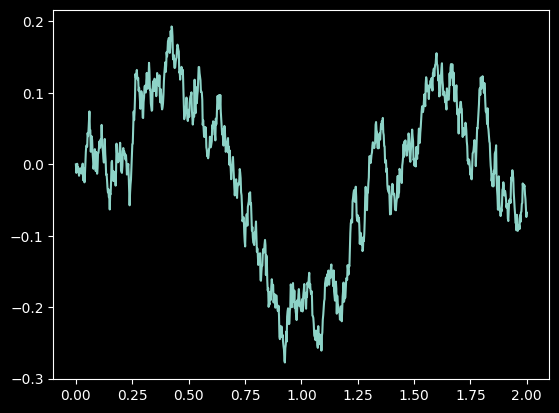

In [109]:
# simulate Ornstein-Uhlenbeck Process
import numpy as np
import matplotlib.pyplot as plt
t_0 = 0 # define model parameters
t_end = 2
length = 1000
theta = 1.1
mu = 0
sigma = 0.3
t = np.linspace(t_0,t_end,length) # define time axis
dt = np.mean(np.diff(t))

y = np.zeros(length)
y0 = np.random.normal(loc=0.0,scale=1.0) # initial condition
drift = lambda y,t: theta*(mu-y) # define drift term, google to learn about lambda
diffusion = lambda y,t: sigma # define diffusion term
noise = np.random.normal(loc=0.0,scale=1.0,size=length)*np.sqrt(dt) #define noise process
# solve SDE
for i in range(1,length):
    y[i] = y[i-1] + drift(y[i-1],i*dt)*dt + diffusion(y[i-1],i*dt)*noise[i]

plt.plot(t,y)

plt.show()